### <font color = 'purple'> DATA 255 - HOMEWORK-5: PART-2 Least Square GANs

#### <font color = 'purple'> Repeat the steps 1-6 with Least Square GAN and compare it with GAN results

#### <font color = 'blue'>Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

fashion_mnist = FashionMNIST(root='data',
                             train=True,
                             download=True,
                             transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|██████████| 26421880/26421880 [00:05<00:00, 4674482.30it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 67588.31it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2614800.48it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9600834.59it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [2]:
img, label = fashion_mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

<font color = 'blue'>Pixel values ranges from -1 to 1 as we have transformed in the first step

In [3]:
# denormalising to view the image
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

<font color = 'blue'>Using the dictionary label_map to define the label names

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}


Label: Ankle Boot


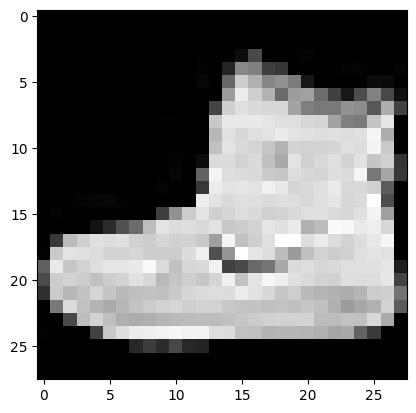

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
label_name = labels_map[label]
print('Label:', label_name)


<font color = 'blue'> Loading the image in batches

In [6]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([4, 0, 3, 6, 4, 3, 7, 5, 5, 1, 3, 4, 6, 0, 2, 6, 0, 4, 3, 7, 4, 4, 6, 7,
        4, 2, 4, 4, 6, 8, 7, 0, 1, 9, 0, 6, 1, 3, 3, 1, 5, 0, 5, 8, 1, 8, 9, 7,
        5, 9, 1, 9, 8, 8, 6, 1, 4, 4, 2, 7, 5, 0, 1, 7, 2, 3, 2, 7, 5, 6, 6, 4,
        4, 1, 5, 2, 9, 3, 9, 5, 8, 3, 1, 7, 5, 1, 3, 9, 6, 9, 4, 5, 1, 2, 9, 6,
        7, 1, 6, 5])


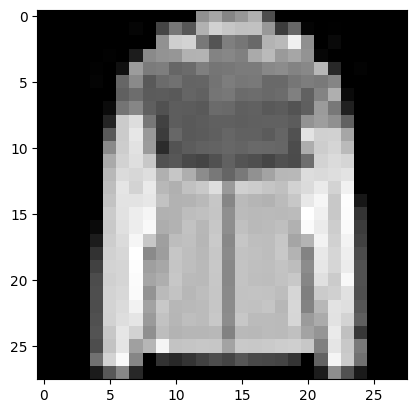

In [7]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
device

device(type='cuda')

### <font color = 'blue'>Step2. Train the LSGAN model to produce images in this new domain.

<font color = 'blue'>The main difference between LSGAN and GAN is in their loss function and training objective. For GAN, the loss function used is binary cross entropy for both generator as well as discriminator, while LSGAN uses a least square loss function i.e mean squared error for both generator and discriminator.

<font color = 'blue'>In LSGAN, the generator tries to minimize the squared difference between generated samples and real samples and the discriminator tries to minimize the squared difference between its predictions for real and generated samples. The objective is to minimize the squared error between generated and real samples.

#### <font color = 'brown'> Discriminator Network

<font color = 'blue'> Taking a simple feedforward NN for the discriminator. Each image of 28X28 as a vector of size 784

In [10]:
image_size = 784
hidden_size = 256

In [11]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

<font color = 'blue'> Moving model to our device

In [12]:
D.to(device);

#### <font color = 'brown'> Generator Network

<font color = 'blue'> Using feedfoward neural network with 3 layers for generator
<font color = 'blue'> Input: A vector or a matrix that is used as a seed for generating an image.
<font color = 'blue'> Output : vector of size 784, transformable to 28X28 pixel image

In [13]:
latent_size = 64

In [14]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

<font color = 'blue'>Note that since the outputs of the TanH activation lie in the range `[-1,1]`, we have applied the same transformation to the images in the training dataset. Let's generate an output vector using the generator and view it as an image by transforming and denormalizing the output.

In [15]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

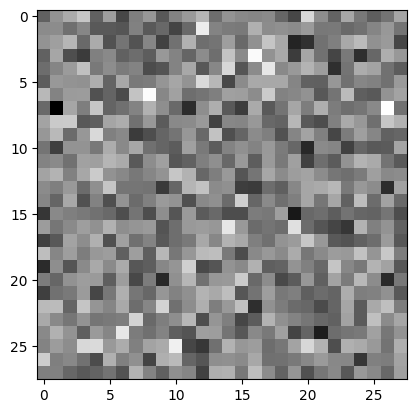

In [16]:
plt.imshow(gen_imgs[0], cmap='gray');

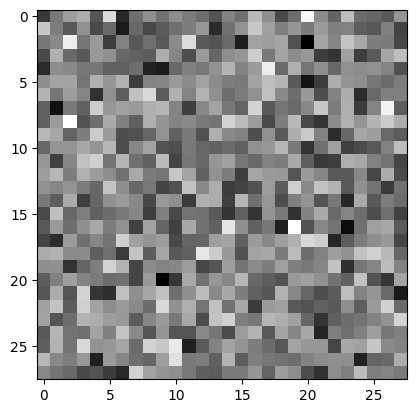

In [17]:
plt.imshow(gen_imgs[1], cmap='gray');

<font color = 'blue'> Outputs from the generator is just a random noise

In [18]:
G.to(device);

#### <font color = 'brown'>Training the Discriminator

<font color = 'blue'> Discriminator is used to classify if the image generated by generator is real or fake. Mostly a binary classification problem, therefor using binary cross entropy loss function

Here we have changed the loss function to MSE loss

In [19]:
criterion = nn.MSELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [20]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):

    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = (d_loss_real + d_loss_fake) / 2
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

#### <font color = 'brown'>Training the Generator

In [21]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [22]:
def train_generator():

    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

#### <font color = 'blue'>Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.

#### <font color = 'brown'>Train the Model

<font color = 'blue'> Creating a directory to save outputs from generator

In [23]:
import os

sample_dir_fashion_mnist = 'samples_lsgan'
if not os.path.exists(sample_dir_fashion_mnist):
    os.makedirs(sample_dir_fashion_mnist)

<font color = 'blue'> Saving a batch of real images so as to compare with the generated image

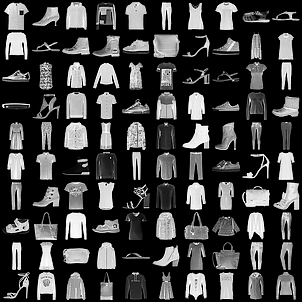

In [24]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir_fashion_mnist, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir_fashion_mnist, 'real_images.png'))

<font color = 'blue'> Saving the generated image at the end of every epoch. Also using a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model.

Saving fake_images-0000.png


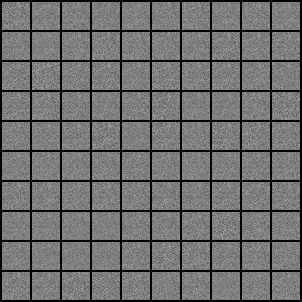

In [25]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir_fashion_mnist, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir_fashion_mnist, 'fake_images-0000.png'))

<font color = 'blue'> Training starts. We first train the discriminator and then generator

In [26]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0061, g_loss: 0.8869, D(x): 0.97, D(G(z)): 0.09
Epoch [0/300], Step [400/600], d_loss: 0.0021, g_loss: 0.9421, D(x): 0.99, D(G(z)): 0.05
Epoch [0/300], Step [600/600], d_loss: 0.0036, g_loss: 0.9749, D(x): 0.97, D(G(z)): 0.04
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0034, g_loss: 0.9505, D(x): 0.99, D(G(z)): 0.02
Epoch [1/300], Step [400/600], d_loss: 0.0017, g_loss: 0.9918, D(x): 0.99, D(G(z)): 0.01
Epoch [1/300], Step [600/600], d_loss: 0.0032, g_loss: 0.9670, D(x): 0.99, D(G(z)): 0.06
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0007, g_loss: 0.9622, D(x): 1.00, D(G(z)): 0.02
Epoch [2/300], Step [400/600], d_loss: 0.0023, g_loss: 0.9523, D(x): 1.00, D(G(z)): 0.05
Epoch [2/300], Step [600/600], d_loss: 0.0120, g_loss: 0.9821, D(x): 0.97, D(G(z)): 0.01
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.0022, g_loss: 0.9637, D(x): 0.99, D(G(z)): 0.02
Epoch [3/300], Step [400/6

#### <font color = 'blue'>Step4. Save the model weights in the folder to be used later.

In [27]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G_LSGAN.ckpt')
torch.save(D.state_dict(), 'D_LSGAN.ckpt')

<font color = 'blue'> Visualising the generated images at the given epoch

In [28]:
from IPython.display import Image
from torchvision.utils import save_image

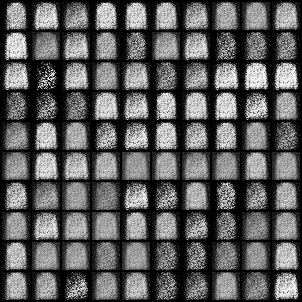

In [36]:
Image('./samples_lsgan/fake_images-0005.png')

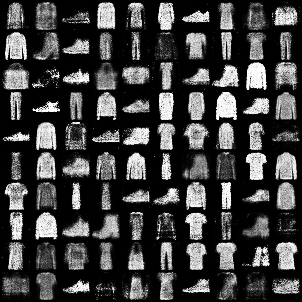

In [37]:
Image('./samples_lsgan/fake_images-0100.png')

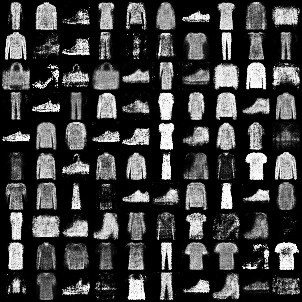

In [38]:
Image('./samples_lsgan/fake_images-0200.png')

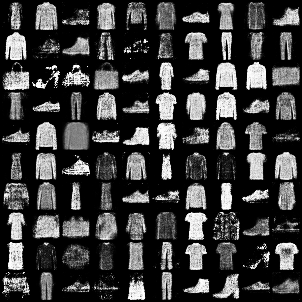

In [39]:
Image('./samples_lsgan/fake_images-0300.png')

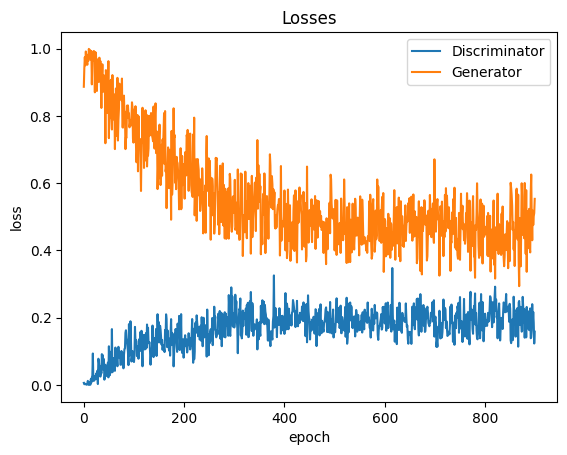

In [33]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

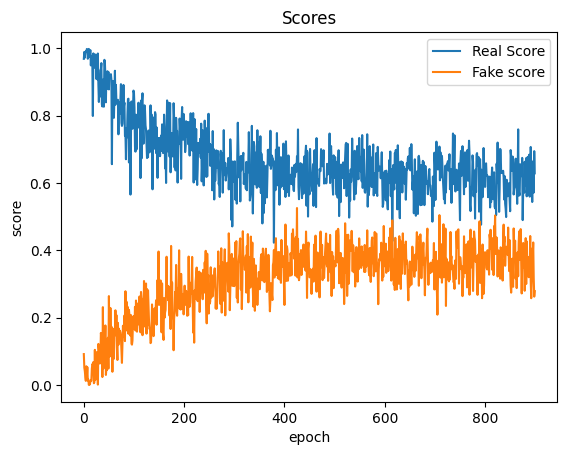

In [40]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

<font color = 'blue'>From the loss Curves, we can see, the generator loss (orange) starts high (~1.0) and gradually decreases to stabilize around 0.4-0.5 and the discriminator loss (blue) starts near 0 and gradually increases to stabilize around 0.2. Both losses show significant fluctuations but have generally stabilized.

<font color = 'blue'>From the score Curves, we see real scores start high and gradually decrease to stabilize around 0.6-0.7 and fake scores start near 0 and gradually increase to stabilize around 0.3-0.4. The separation between real and fake scores seems to remain consistent.

<font color = 'blue'>Model shows relatively stable training and fluctuations are within bounds, and generator and discriminator seems to be learning in balance, as no one is dominating the other. However, there is still significant noise in both curves even after these many epochs. The fake score closer to 0.5 suggests more realistic image generation. Therefore, we can try retraining further to see more improvement.

#### <font color = 'blue'>Step5. Load the model using the saved weights.

In [34]:
G.load_state_dict(torch.load('G_LSGAN.ckpt'))
D.load_state_dict(torch.load('D_LSGAN.ckpt'))

<ipython-input-34-dab99ed29cf4>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('G_LSGAN.ckpt'))
<ipython-input-34-dab99ed29cf4>:2: FutureWarni

<All keys matched successfully>

#### <font color = 'blue'>Step 6: Re-train the LSGAN model to see if you can improve.

<font color = 'blue'> We have defined the optimizer again for generator and discriminator with lr = 0.0001 and loaded the saved model on device

In [41]:
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0001)

# Ensure models are on the correct device
D.to(device)
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

<font color = 'blue'>Making new directory to save the generator output from retrained model

In [42]:
import os

sample_dir_fashion_mnist_retrain = 'samples_lsgan_retrain'
if not os.path.exists(sample_dir_fashion_mnist_retrain):
    os.makedirs(sample_dir_fashion_mnist_retrain)

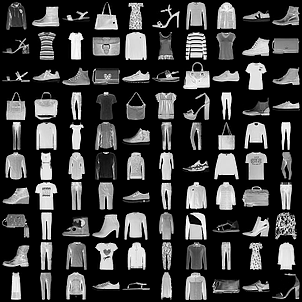

In [43]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir_fashion_mnist_retrain, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir_fashion_mnist_retrain, 'real_images.png'))

Saving fake_images-0000.png


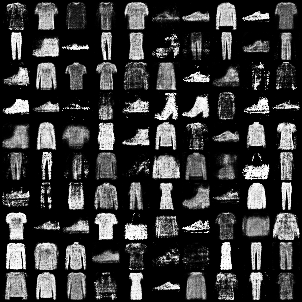

In [44]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images_retrain(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir_fashion_mnist_retrain, fake_fname), nrow=10)

# Before training
save_fake_images_retrain(0)
Image(os.path.join(sample_dir_fashion_mnist_retrain, 'fake_images-0000.png'))

<font color = 'blue'>Retraining the saved model with 100 epochs and changed lr

In [45]:
%%time

num_epochs = 100
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images_retrain(epoch+1)

Epoch [0/100], Step [200/600], d_loss: 0.1833, g_loss: 0.4123, D(x): 0.59, D(G(z)): 0.34
Epoch [0/100], Step [400/600], d_loss: 0.1888, g_loss: 0.3896, D(x): 0.61, D(G(z)): 0.39
Epoch [0/100], Step [600/600], d_loss: 0.1834, g_loss: 0.4382, D(x): 0.63, D(G(z)): 0.39
Saving fake_images-0001.png
Epoch [1/100], Step [200/600], d_loss: 0.1874, g_loss: 0.4573, D(x): 0.61, D(G(z)): 0.39
Epoch [1/100], Step [400/600], d_loss: 0.1707, g_loss: 0.4261, D(x): 0.65, D(G(z)): 0.38
Epoch [1/100], Step [600/600], d_loss: 0.1956, g_loss: 0.4279, D(x): 0.59, D(G(z)): 0.39
Saving fake_images-0002.png
Epoch [2/100], Step [200/600], d_loss: 0.1933, g_loss: 0.4239, D(x): 0.58, D(G(z)): 0.38
Epoch [2/100], Step [400/600], d_loss: 0.1908, g_loss: 0.4536, D(x): 0.62, D(G(z)): 0.41
Epoch [2/100], Step [600/600], d_loss: 0.1946, g_loss: 0.4043, D(x): 0.59, D(G(z)): 0.37
Saving fake_images-0003.png
Epoch [3/100], Step [200/600], d_loss: 0.1910, g_loss: 0.3525, D(x): 0.63, D(G(z)): 0.40
Epoch [3/100], Step [400/6

#### <font color = 'blue'>Step 7: Save the model weights without using checkpoints.

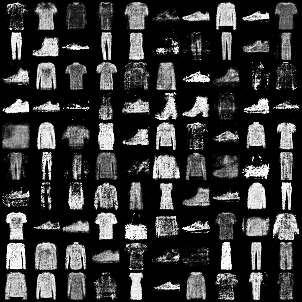

In [46]:
Image('./samples_lsgan_retrain/fake_images-0005.png')

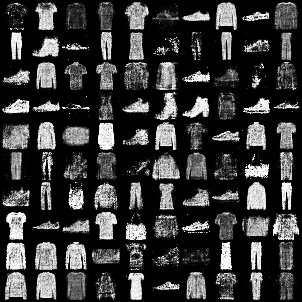

In [47]:
Image('./samples_lsgan_retrain/fake_images-0030.png')

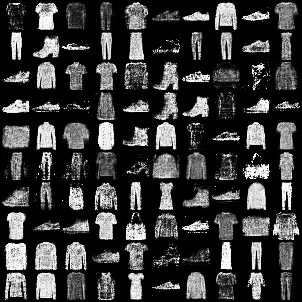

In [48]:
Image('./samples_lsgan_retrain/fake_images-0080.png')

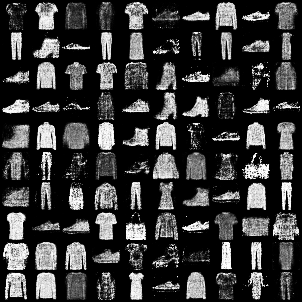

In [49]:
Image('./samples_lsgan_retrain/fake_images-0100.png')

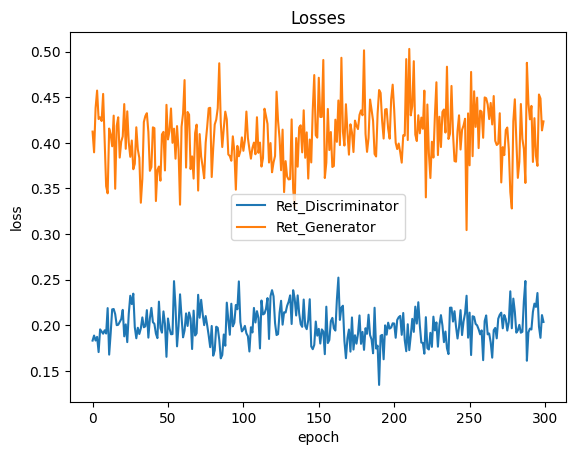

In [50]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Ret_Discriminator', 'Ret_Generator'])
plt.title('Losses');

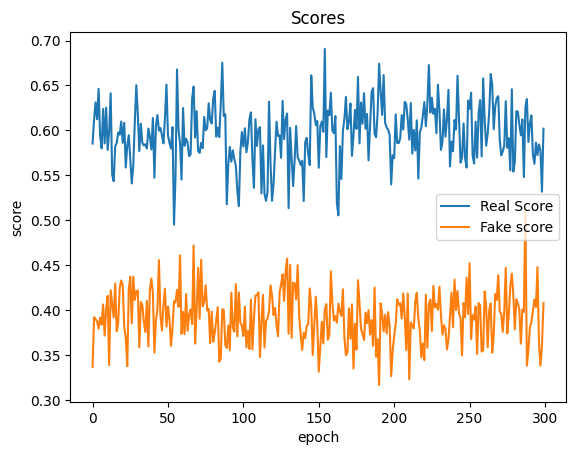

In [51]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

#### <font color = 'blue'>Comparison with GAN results

<font color = 'blue'>From these retrained model curves, we see both generator and discriminator losses are much more stable compared to the previous training. Generator loss is consistently around 0.4-0.45 and the discriminator loss stays stable around 0.2

<font color = 'blue'>From the score curves, we see real scores in blue consistently stay around 0.55-0.65 and fake scores in orange maintain a range of 0.35-0.45. The gap between real and fake scores is smaller and is more consistent around 0.2

<font color = 'blue'>We see improvements from previous training in terms of stability, having consistent performance across epochs. We also see a better balance in generator and discriminator now, and fake score being to 0.5 alos tells the generator is producing more realistic images.
Also, the gap maintained between real and fake scores indicates the discriminator is still able to distinguish between them.

<font color = 'blue'>For these reasons, we can conclude that LSGAN training was more robust as compared to Basic GAN training, as with LSGAN we got more stable results, better convergence and more consistent performance. 

#### <font color = 'blue'> Thank You!